# Importing Libraries

In [1]:
# Importing Libraries
import os, pickle, glob, sys
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-x8v3kccb because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Initializing SparkSession
sc = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
	.config("spark.executor.memory", "10g") \
    .config('spark.executor.instances', 5) \
	.getOrCreate()
print(sc)

In [3]:
# First time data zip unpacking
#!unzip ./traffic_congestion.zip

In [4]:
csv_file = "./us_congestion_2016_2022/us_congestion_2016_2022.csv"

In [5]:
df = sc.read.csv(csv_file, header=True, inferSchema=True)

# Exploring Data

In [6]:
# Inspecting First Row
first_row = df.take(1)[0]
print(first_row)

Row(ID='C-1', Severity=0, Start_Lat=42.410881, Start_Lng=-71.147995, StartTime=datetime.datetime(2020, 11, 10, 14, 54), EndTime=datetime.datetime(2020, 11, 10, 16, 29, 27), Distance(mi)=3.990000009536743, DelayFromTypicalTraffic(mins)=0.0, DelayFromFreeFlowSpeed(mins)=4.0, Congestion_Speed='Moderate', Description='Delays of four minutes and delays increasing on Massachusetts Ave Westbound between MA-2A Massachusetts Ave and US-3 Mass Ave. Average speed 15 mph.', Street='Wyman Ter', City='Arlington', County='Middlesex', State='MA', Country='US', ZipCode='02474-6726', LocalTimeZone='US/Eastern', WeatherStation_AirportCode='KBED', WeatherTimeStamp=datetime.datetime(2020, 11, 10, 14, 51), Temperature(F)=64.0, WindChill(F)=64.0, Humidity(%)=63.0, Pressure(in)=29.93, Visibility(mi)=10.0, WindDir='SSW', WindSpeed(mph)=7.0, Precipitation(in)=0.0, Weather_Event=None, Weather_Conditions='Fair')


In [7]:
# Check the schema
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- DelayFromTypicalTraffic(mins): double (nullable = true)
 |-- DelayFromFreeFlowSpeed(mins): double (nullable = true)
 |-- Congestion_Speed: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- LocalTimeZone: string (nullable = true)
 |-- WeatherStation_AirportCode: string (nullable = true)
 |-- WeatherTimeStamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- WindChill(F): double (nullable = true)
 |-- Humidity(%): double 

In [8]:
def shape(df):
    num_rows = df.count()
    num_cols = len(df.columns)
    return num_rows, num_cols

df_rows, df_cols = shape(df)
print("DataFrame has {} rows and {} columns.".format(df_rows, df_cols))

DataFrame has 33304199 rows and 30 columns.


# Data Cleaning and Filtering

In [9]:
# Handle missing values
df = df.dropna()

# Remove duplicates
df = df.dropDuplicates()

In [10]:
# Filtering Fields
# Filter out specific fields we want to keep
fields_to_keep = ['ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event']

# Filter out data that might be useless, like Delays that are less than 5 minutes. Reduces data to around 5 million data
filtered_df = df.select(*fields_to_keep).where(col("State").isNotNull()).where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)
filtered_df.show()

+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|Weather_Event|
+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+
| C-88197|       2|           5.119999885559082|2018-11-28 21:18:00|        Moderate|       29.78|          10.0|          15.0|              0.0|         Snow|
| C-89281|       1|           6.269999980926514|2018-11-28 12:01:00|        Moderate|       29.92|           9.0|          18.4|              0.0|         Snow|
|C-106956|       2|            18.1200008392334|2018-11-28 23:42:00|            Slow|        29.9|           4.0|           8.1|              0.0|         Snow|
|C-121261|       2|           7.19

In [11]:
# Grouping by State
#state_count_df = filtered_df.groupBy("State").count()
#state_count_df.show()

In [12]:
# Cleaning 'Congestion_Speed' Column
df = df.withColumn("Congestion_Speed", when(col("Congestion_Speed") == "Slow", 0).when(col("Congestion_Speed") == "Moderate", 1).when(col("Congestion_Speed") == "Fast", 3))
df.show()

+--------+--------+---------+------------------+-------------------+-------------------+------------------+-----------------------------+----------------------------+----------------+--------------------+-----------------+----------------+----------+-----+-------+----------+-------------+--------------------------+-------------------+--------------+------------+-----------+------------+--------------+-------+--------------+-----------------+-------------+------------------+
|      ID|Severity|Start_Lat|         Start_Lng|          StartTime|            EndTime|      Distance(mi)|DelayFromTypicalTraffic(mins)|DelayFromFreeFlowSpeed(mins)|Congestion_Speed|         Description|           Street|            City|    County|State|Country|   ZipCode|LocalTimeZone|WeatherStation_AirportCode|   WeatherTimeStamp|Temperature(F)|WindChill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|WindDir|WindSpeed(mph)|Precipitation(in)|Weather_Event|Weather_Conditions|
+--------+--------+---------+-------------

In [13]:
# Grouping by 'Weather_Event' and Counting
weather_counts = filtered_df.groupBy("Weather_Event").count()
weather_counts.show()
#Thunderstorm, Rain, Fog, Snow, Tornado, Hail

+--------------------+------+
|       Weather_Event| count|
+--------------------+------+
|        Thunderstorm|   133|
|   Fog ;Thunderstorm|    75|
|  Rain ;Thunderstorm|   535|
|  Snow ;Thunderstorm|   195|
|                 Fog|  2807|
|Rain ;Snow ;Thund...|    11|
|Fog ;Snow ;Thunde...|   271|
|          Rain ;Snow|  1034|
|                Snow|148239|
|                Rain| 46503|
|          Snow ;Hail|     3|
|           Fog ;Rain|   813|
|Fog ;Rain ;Thunde...|     5|
|           Fog ;Snow| 49844|
|     Fog ;Rain ;Snow|    17|
|          Rain ;Hail|     2|
|Rain ;Hail ;Thund...|     1|
+--------------------+------+



In [14]:
# 1. Extract columns for the Accident table
accident_df = df.select(
    "ID", "Severity", "Start_Lat", "Start_Lng",
    "StartTime", "EndTime", "Distance(mi)",
    "DelayFromTypicalTraffic(mins)", "DelayFromFreeFlowSpeed(mins)",
    "Congestion_Speed", "Description"
)

# 2. Extract columns for the Location table
location_df = df.select(
    "ID", "Street", "City", "County", "State",
    "Country", "ZipCode", "LocalTimeZone"
)

# 3. Extract columns for the Weather table
weather_df = df.select(
    "ID", "WeatherStation_AirportCode", "WeatherTimeStamp",
    "Temperature(F)", "WindChill(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "WindDir",
    "WindSpeed(mph)", "Precipitation(in)",
    "Weather_Event", "Weather_Conditions"
)

testing_df = df.select(
    'ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 
    'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 
    'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event'
)

# Write the normalized DataFrames to separate Parquet files
accident_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")
location_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/location_table.parquet")
weather_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/weather_table.parquet")
testing_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")

# Data Visualization

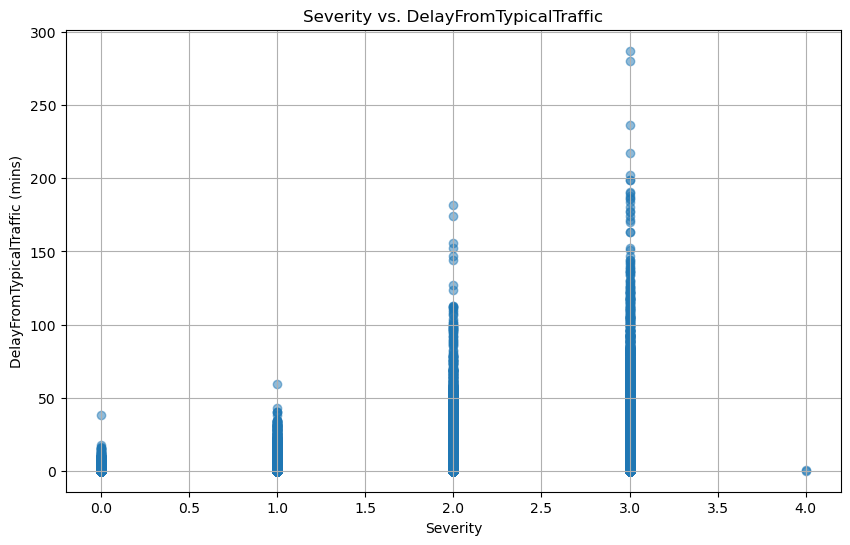

In [15]:
import matplotlib.pyplot as plt

# Read the Parquet file containing the Accident Table
accident_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")

# Select only Severity and DelayFromTypicalTraffic columns
severity_delay_df = accident_df.select("Severity", "DelayFromTypicalTraffic(mins)")

# Convert DataFrame to Pandas DataFrame
severity_delay_pd = severity_delay_df.toPandas()

# Plot Severity vs. DelayFromTypicalTraffic
plt.figure(figsize=(10, 6))
plt.scatter(severity_delay_pd['Severity'], severity_delay_pd['DelayFromTypicalTraffic(mins)'], alpha=0.5)
plt.title('Severity vs. DelayFromTypicalTraffic')
plt.xlabel('Severity')
plt.ylabel('DelayFromTypicalTraffic (mins)')
plt.grid(True)
plt.show()

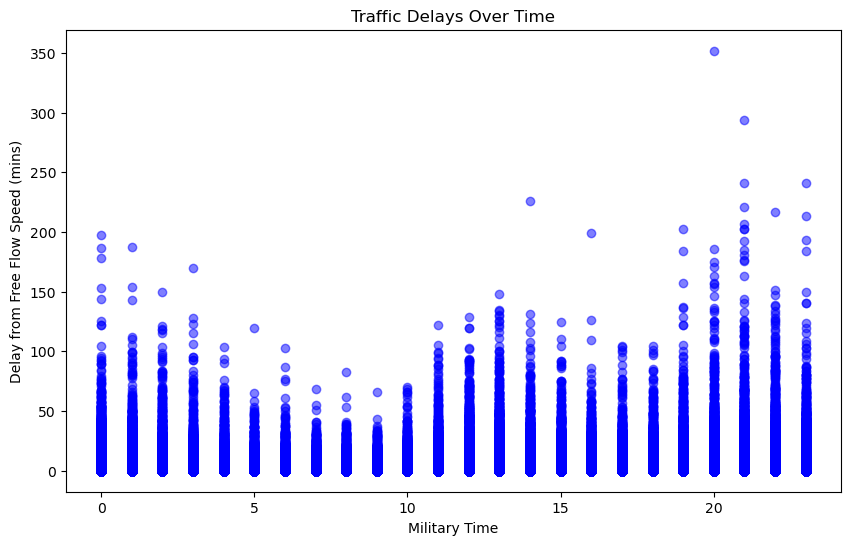

In [16]:
testing_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")
starttime_df = testing_df.select("DelayFromFreeFlowSpeed(mins)", "StartTime")
starttime_df = starttime_df.toPandas()

starttime_df['StartTime'] = pd.to_datetime(starttime_df['StartTime']).dt.hour


plt.figure(figsize=(10, 6))
plt.scatter(starttime_df['StartTime'], starttime_df['DelayFromFreeFlowSpeed(mins)'], color='b', alpha=0.5)
plt.title('Traffic Delays Over Time')
plt.xlabel('Military Time')
plt.ylabel('Delay from Free Flow Speed (mins)')
plt.show()

In [17]:
testing_df.show()

+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|Weather_Event|
+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+
| C-87810|       1|          1.6699999570846558|2018-11-28 10:14:00|               3|       29.75|           1.5|          19.6|              0.0|         Snow|
| C-87967|       0|          0.9200000166893004|2018-11-28 13:05:00|               0|       29.68|           0.8|          19.6|             0.02|         Snow|
| C-89248|       1|           8.220000267028809|2018-11-28 05:47:00|               0|       29.88|           8.0|          13.8|              0.0|         Snow|
| C-90413|       2|           4.76

In [18]:
# Added Weather_Event_Count and filtered out delays that aren't over 5 minutes
df = testing_df.withColumn("Weather_Event_Count", F.size(F.split(testing_df["Weather_Event"], ";")))
df = df.where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)
df.show()

+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|Weather_Event|Weather_Event_Count|
+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+-------------+-------------------+
| C-89248|       1|           8.220000267028809|2018-11-28 05:47:00|               0|       29.88|           8.0|          13.8|              0.0|         Snow|                  1|
| C-91036|       1|           5.619999885559082|2018-11-28 12:27:00|               1|       29.56|           0.8|          16.1|             0.01|         Snow|                  1|
|C-107165|       2|           5.829999923706055|2018-11-28 17:16:00|               3|       29.

In [19]:
df = df.toPandas()

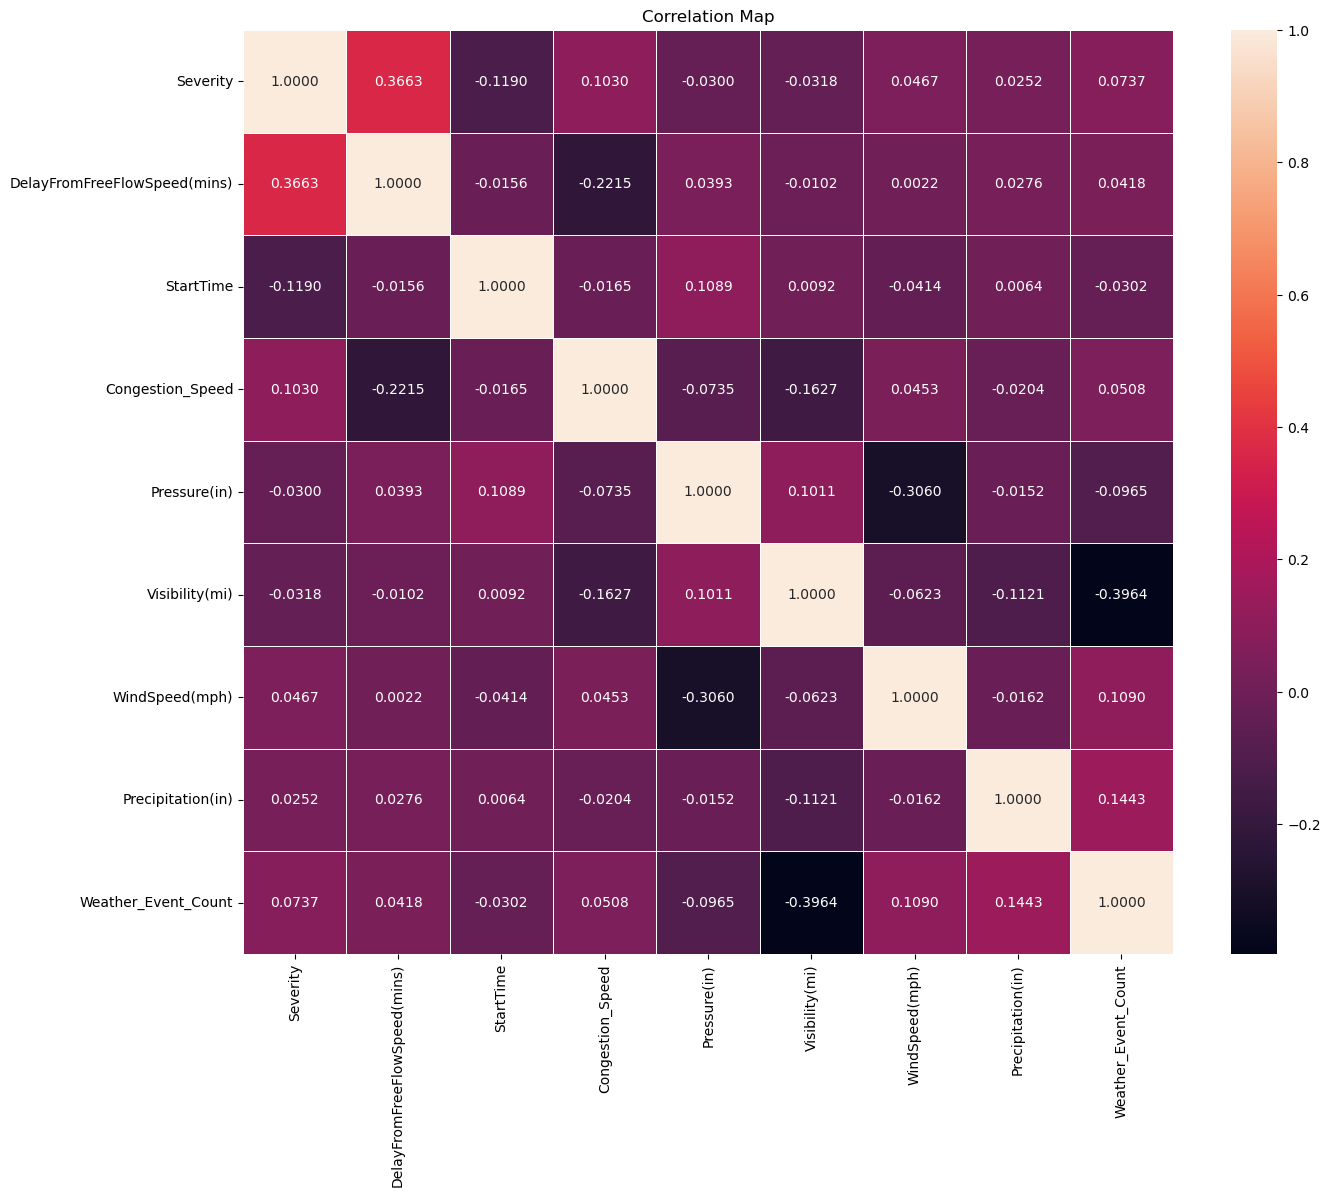

In [20]:
df_correlation = df[['Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Event_Count']]
plt.figure(figsize=(15,12))
plt.title('Correlation Map')
sns.heatmap(df_correlation.corr(), annot=True, fmt=".4f", linewidths=0.5)
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [22]:
# Finishing Preprocessing
# Load the preprocessed data
accident_df = pd.read_parquet(os.getcwd() + "/parquet_data/accident_df.parquet")
weather_df = pd.read_parquet(os.getcwd() + "/parquet_data/weather_table.parquet")

# Merge relevant columns from accident_df and weather_df
merged_df = accident_df[['ID', 'Congestion_Speed']].merge(
    weather_df[['ID', 'WeatherTimeStamp', 'Pressure(in)']], on='ID', how='inner')

# Drop rows with missing values
merged_df.dropna(inplace=True)

In [23]:
# Splitting the data into train and test sets
X = merged_df[['Pressure(in)']]
y = merged_df['Congestion_Speed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the first model: Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)

Train RMSE: 1.1714642543584903
Test RMSE: 1.1699850428341243


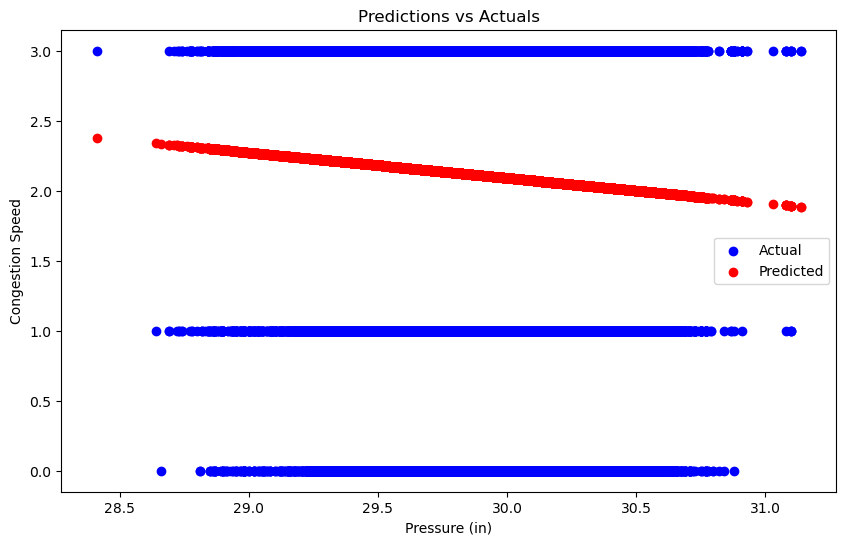

In [24]:
# Evaluation: Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Plotting predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, test_preds, color='red', label='Predicted')
plt.xlabel('Pressure (in)')
plt.ylabel('Congestion Speed')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()

# RMSE Interpretation and Comparison
On average, the predicted congestion speed deviates from the actual congestion speed by approximately 1.171 units

On average, the predicted congestion speed deviates from the actual congestion speed by approximately 1.170 units

The train RMSE and test RMSE are very close to each other which means that the model generalizes well to new, unseen data. Also, there isn't a significant difference between the training error and the test error meaning that the model is not overfitting or underfitting

# Graph Interpretation
The pattern of the red dots (predictions) suggests that the linear Regression Model is predicting a line that doesn't capture the variability of the actual congestion speeds (which are more dispersed)

# Next Steps
More complex models, such as DTs, RFs, Gradient Boosting, and Neural Nets should help in capturing non-linear relationships and variablility in the data

Random Forest Train RMSE: 1.1683265209258846
Random Forest Test RMSE: 1.166988589658763


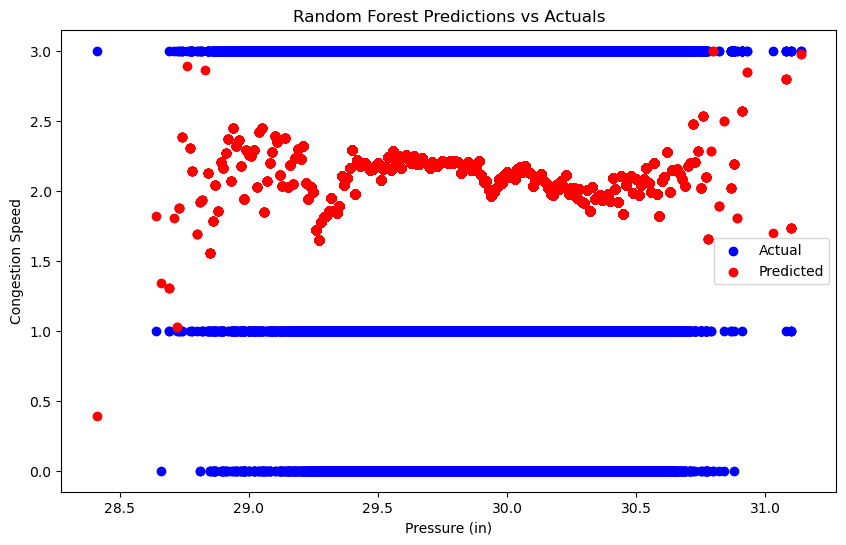

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_train_preds = rf_model.predict(X_train_scaled)
rf_test_preds = rf_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_preds))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))
print("Random Forest Train RMSE:", rf_train_rmse)
print("Random Forest Test RMSE:", rf_test_rmse)

# Plotting predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, rf_test_preds, color='red', label='Predicted')
plt.xlabel('Pressure (in)')
plt.ylabel('Congestion Speed')
plt.title('Random Forest Predictions vs Actuals')
plt.legend()
plt.show()

# Evaluation of Random Forest Model
The Random Forest model shows very similar RMSE values for both the training and test datasets, similar to the Linear Regression model. This suggests that the model is not overfitting and has good generalization ability.

Graph Interpretatimodel.
The Random Forest predictions (red dots) appear to capture some non-linear patterns compared to the Linear Regression model. However, the predictions still show a substantial spread around the actual values, indicating that there might be other factors influencing congestion speed that are not captured by just using pressure as a predictor.

Evaluation of Underfitting/Overfitting
Underfitting: Both the Linear Regression and Random Forest models seem to underfit the data to some extent, as indicated by the substantial spread between actual and predicted values in the scatter plots.
Overfitting: There is no significant evidence of overfitting as the RMSE values for both training and test datasets are very close

Gradient Boosting Train RMSE: 1.1686818156484327
Gradient Boosting Test RMSE: 1.1671017369772374


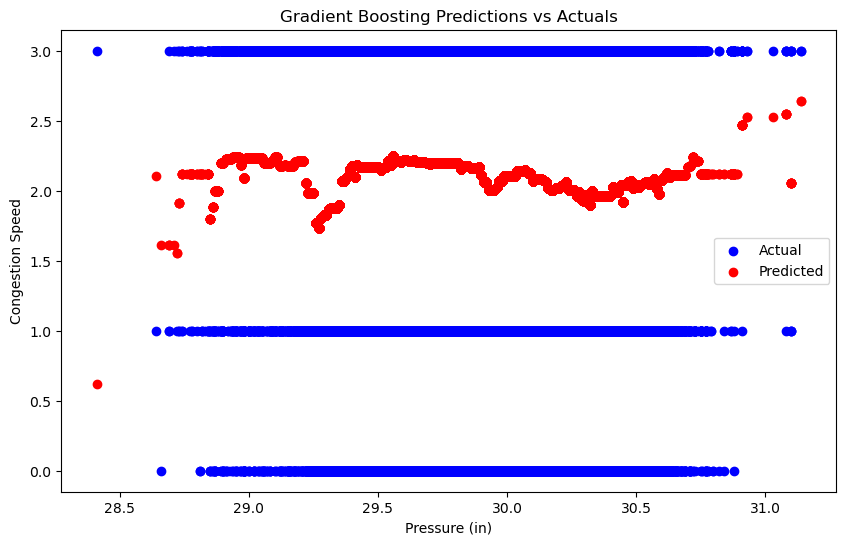

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
gb_train_preds = gb_model.predict(X_train_scaled)
gb_test_preds = gb_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE
gb_train_rmse = np.sqrt(mean_squared_error(y_train, gb_train_preds))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_test_preds))
print("Gradient Boosting Train RMSE:", gb_train_rmse)
print("Gradient Boosting Test RMSE:", gb_test_rmse)

# Plotting predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, gb_test_preds, color='red', label='Predicted')
plt.xlabel('Pressure (in)')
plt.ylabel('Congestion Speed')
plt.title('Gradient Boosting Predictions vs Actuals')
plt.legend()
plt.show()

# Analysis of Gradient Boosting
The RMSE values for both the training and test datasets remain very close to each other and similar to the previous models, meaning a good generalization without overfitting

Graph Interpretation
The Gradient Boosting model appears to capture non-linear patterns slightly better than Linear Regression and Random Forest. However, the spread around the actual values is still quite significant, indicating that other factors influencing congestion speed are not being captured fully by pressure alone

Evaluation of Underfitting/Overfitting
Underfitting: All three models (Linear Regression, Random Forest, and Gradient Boosting) show a level of underfitting, as evidenced by the spread of predictions not fully aligning with the actual values

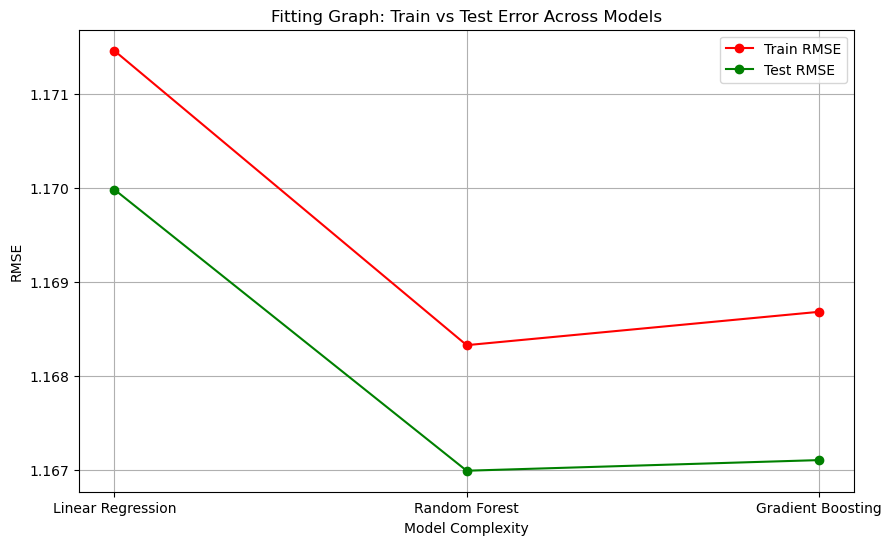

In [27]:
# RMSE values for the models
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
train_rmse = [1.1714642543584903, 1.1683265209258846, 1.1686818156484327]
test_rmse = [1.1699850428341243, 1.166988589658763, 1.1671017369772374]

# Plotting the fitting graph
plt.figure(figsize=(10, 6))

plt.plot(models, train_rmse, label='Train RMSE', marker='o', color='red')
plt.plot(models, test_rmse, label='Test RMSE', marker='o', color='green')

plt.xlabel('Model Complexity')
plt.ylabel('RMSE')
plt.title('Fitting Graph: Train vs Test Error Across Models')
plt.legend()
plt.grid(True)
plt.show()